## Introduction to Manual Feature Engineering
https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
앞서 했던 커널에 이어서 더 발전시키는 커널
* In an earlier notebook, we used only the application data in order to build a model. The best model we made from this data achieved a score on the leaderboard around 0.74. In order to better this score, we will have to include more information from the other dataframes.
* bureau : 보고된 다른 금융 기관과의 고객 대출에 관한 정보
* bureau_balance : 이전 대출에 대한 월간 정보
* 데이터 종류가 많으니까 앞서서는 application 데이터를 사용했고 이번에는 다른 데이터 추가 사용 -> 성능이 향상 되는지 확인하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
# Read in bureau
bureau = pd.read_csv('./input/House/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


ID 가 중복이 있음을 알 수 있음. 결측치도 보이고, groupby 를 하기전에 몇 개나 있는지 알아보면 좋을 것 같음. 

In [3]:
bureau['SK_ID_CURR'].value_counts()

120860    116
169704     94
318065     78
251643     61
425396     60
         ... 
206292      1
216537      1
106359      1
100212      1
250544      1
Name: SK_ID_CURR, Length: 305811, dtype: int64

In [4]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column 
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()
# groupby 하면 column 이 주르륵 생기는데, 그중에서 SK_ID_BUREAU 만 뽑아내서 카운트

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
train = pd.read_csv('./input/House/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values with 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# Assessing Usefulness of New Variable with r-value
# 새로운 변수가 유의미한지 알아보자. kde plot 으로 알아볼 것인데, 함수를 정의해서 편리하게 할 것임. 
# Plots the distribution of a variable colored by value of the target

def kde_target(var_name, df):
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    # calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    plt.figure(figsize = (12, 6))
    
    # plot the distribution for target == 0 and == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    plt.xlabel(var_name, fontsize = 20)
    plt.ylabel('Density', fontsize = 20)
    plt.title('%s Distribution' % var_name, fontsize = 20)
    plt.legend()
    
    print('The correlation between %s and the Target is %0.4f' % (var_name, corr))
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid = %0.4f' % avg_repaid)

The correlation between EXT_SOURCE_3 and the Target is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


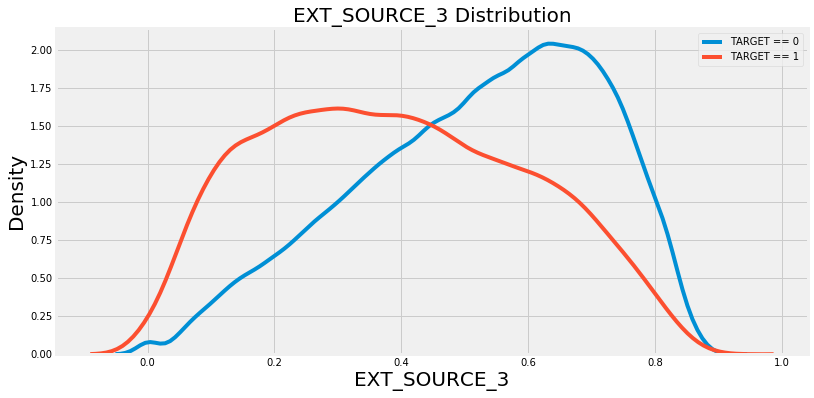

In [7]:
kde_target('EXT_SOURCE_3', train)
# plot 잘 나오는 거 확인.

The correlation between previous_loan_counts and the Target is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


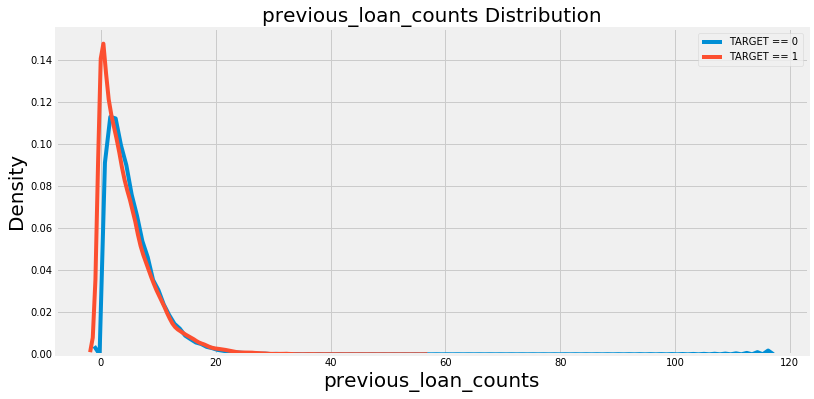

In [8]:
kde_target('previous_loan_counts', train)

* 뚜렷한 특징이 안보임. 차이가 있는지 모르겠음. target 과 상관이 있는지 모호함.  
* 그래서 bureau dataframe 에서 수치형 칼럼들을 더 가지고 오겠음.

In [9]:
# Aggregating Numeric Columns
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

* groupby, agg function
* The agg function will only calculate the values for the numeric columns where the operation is considered valid. We will stick to using 'mean', 'max', 'min', 'sum' but any function can be passed in here. We can even write our own function and use it in an agg call.  
* agg 는 수치형 컬럼에 대해서 통계 계산을 해줌. 여러 가지 한번에, + 우리가 정의한 함수도 가능

In [10]:
bureau_agg.columns # Multi Index 상태

MultiIndex([(            'SK_ID_CURR',      ''),
            (           'DAYS_CREDIT', 'count'),
            (           'DAYS_CREDIT',  'mean'),
            (           'DAYS_CREDIT',   'max'),
            (           'DAYS_CREDIT',   'min'),
            (           'DAYS_CREDIT',   'sum'),
            (    'CREDIT_DAY_OVERDUE', 'count'),
            (    'CREDIT_DAY_OVERDUE',  'mean'),
            (    'CREDIT_DAY_OVERDUE',   'max'),
            (    'CREDIT_DAY_OVERDUE',   'min'),
            (    'CREDIT_DAY_OVERDUE',   'sum'),
            (   'DAYS_CREDIT_ENDDATE', 'count'),
            (   'DAYS_CREDIT_ENDDATE',  'mean'),
            (   'DAYS_CREDIT_ENDDATE',   'max'),
            (   'DAYS_CREDIT_ENDDATE',   'min'),
            (   'DAYS_CREDIT_ENDDATE',   'sum'),
            (     'DAYS_ENDDATE_FACT', 'count'),
            (     'DAYS_ENDDATE_FACT',  'mean'),
            (     'DAYS_ENDDATE_FACT',   'max'),
            (     'DAYS_ENDDATE_FACT',   'min'),
            (     'D

In [11]:
bureau_agg.columns.levels
# frozenlist : frozen set is just an immutable version of a Python set object
# Due to this, frozen set can be used as key in Dictionary or as element of another set. 

FrozenList([['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'SK_ID_CURR'], ['count', 'mean', 'max', 'min', 'sum', '']])

In [12]:
bureau_agg.columns.levels[0]

Index(['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'SK_ID_CURR'],
      dtype='object')

In [13]:
bureau_agg.columns.levels[1][:-1]
# 맨 뒤에 [:-1] 없으면 '' 이 index 안에 포함되어 있음.

Index(['count', 'mean', 'max', 'min', 'sum'], dtype='object')

In [14]:
# 새로운 변수들 변수명 바꿔서 추가할 준비. multi-level index 라서 그거 해결.
# groupby 하면 멀티레벨 인덱스가 되는 듯
columns = ['SK_ID_CURR']

# iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))

In [15]:
columns

['SK_ID_CURR',
 'bureau_DAYS_CREDIT_count',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_sum',
 'bureau_CREDIT_DAY_OVERDUE_count',
 'bureau_CREDIT_DAY_OVERDUE_mean',
 'bureau_CREDIT_DAY_OVERDUE_max',
 'bureau_CREDIT_DAY_OVERDUE_min',
 'bureau_CREDIT_DAY_OVERDUE_sum',
 'bureau_DAYS_CREDIT_ENDDATE_count',
 'bureau_DAYS_CREDIT_ENDDATE_mean',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_ENDDATE_min',
 'bureau_DAYS_CREDIT_ENDDATE_sum',
 'bureau_DAYS_ENDDATE_FACT_count',
 'bureau_DAYS_ENDDATE_FACT_mean',
 'bureau_DAYS_ENDDATE_FACT_max',
 'bureau_DAYS_ENDDATE_FACT_min',
 'bureau_DAYS_ENDDATE_FACT_sum',
 'bureau_AMT_CREDIT_MAX_OVERDUE_count',
 'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
 'bureau_AMT_CREDIT_MAX_OVERDUE_max',
 'bureau_AMT_CREDIT_MAX_OVERDUE_min',
 'bureau_AMT_CREDIT_MAX_OVERDUE_sum',
 'bureau_CNT_CREDIT_PROLONG_count',
 'bureau_CNT_CREDIT_PROLONG_mean',
 'bureau_CNT_CREDIT_PROLONG_max',
 'bureau_CNT_CREDIT_PROLONG_mi

In [16]:
bureau_agg.columns

MultiIndex([(            'SK_ID_CURR',      ''),
            (           'DAYS_CREDIT', 'count'),
            (           'DAYS_CREDIT',  'mean'),
            (           'DAYS_CREDIT',   'max'),
            (           'DAYS_CREDIT',   'min'),
            (           'DAYS_CREDIT',   'sum'),
            (    'CREDIT_DAY_OVERDUE', 'count'),
            (    'CREDIT_DAY_OVERDUE',  'mean'),
            (    'CREDIT_DAY_OVERDUE',   'max'),
            (    'CREDIT_DAY_OVERDUE',   'min'),
            (    'CREDIT_DAY_OVERDUE',   'sum'),
            (   'DAYS_CREDIT_ENDDATE', 'count'),
            (   'DAYS_CREDIT_ENDDATE',  'mean'),
            (   'DAYS_CREDIT_ENDDATE',   'max'),
            (   'DAYS_CREDIT_ENDDATE',   'min'),
            (   'DAYS_CREDIT_ENDDATE',   'sum'),
            (     'DAYS_ENDDATE_FACT', 'count'),
            (     'DAYS_ENDDATE_FACT',  'mean'),
            (     'DAYS_ENDDATE_FACT',   'max'),
            (     'DAYS_ENDDATE_FACT',   'min'),
            (     'D

In [17]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns # bureau_agg 의 column 들을 columns 에 있는 column 명으로 변경 
bureau_agg.head() # 바뀌었는지 확인

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [18]:
# simply merge with the training data as we did before
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [19]:
# Correlations of Aggregated Values with Target
new_corrs = []

for col in columns:
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))

In [20]:
# Sort the correlations by the absolute value
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:20]

# 정렬을 하는데, 데이터 프레임이랑 key 가 아마 기준일 것 같음. 절대값을 기준으로 정렬하고 리버스는 큰게 위로 오도록 하는 것. 
# reverse False 하면 작은게 맨 위로 올라옴. ascending 과 동일한 기능

[('bureau_DAYS_CREDIT_mean', 0.08972896721998132),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010391),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968697),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920844),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102095),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758624),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997342),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111618),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835924),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073035),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484685),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353060284),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632938),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616267),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332554),
 ('bureau_DAYS_CREDIT_UPDATE_max', 0.028233546896536017),
 ('bureau_AMT_CREDIT_SUM_mean', -0.019956561902304572),
 ('bureau_AMT_CREDIT_SUM_max', -0.01973749650784

* None of the new variables have a significant correlation with the TARGET.
* We can look at the KDE plot of the highest correlated variable, bureau_DAYS_CREDIT_mean, with the target in in terms of absolute magnitude correlation.

The correlation between bureau_DAYS_CREDIT_mean and the Target is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


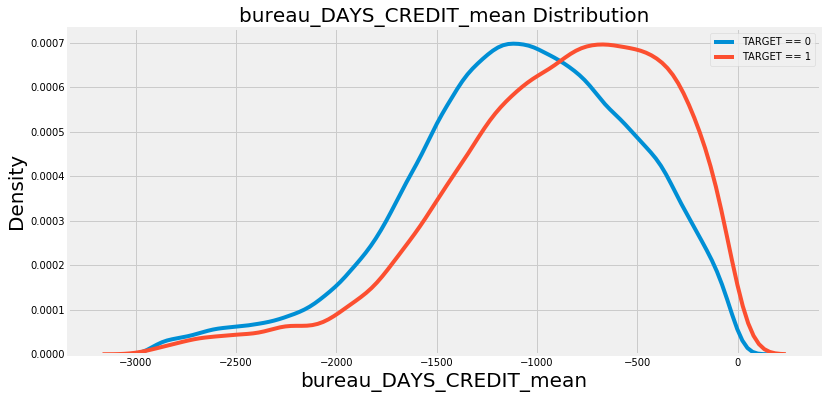

In [21]:
kde_target('bureau_DAYS_CREDIT_mean', train)

* 해당 feature 는 Home Credit 에서 대출을 신청하기 전에 이전 대출이 적용된 날짜 수.
* 음수가 클수록 훨씬 이전에 대출 신청이 있었다는 것을 나타냄. 이 변수를 통해 대출을 상환할 가능성이 높다는 것과 약한 양의 상관관계가 있음을 알 수 있음. 다만 숫자가 작아서 노이즈일 가능성도 존재함. 

* Multiple Comparisons problem (다중 비교 문제)

* data 에 유의미한 상관이 있는 것인지, 우연의 일치로 상관이 있는 것인지 단순 노이즈인지 유의미한 패턴인지 p-value 에 관련된 이야기임.
* 예를 들어, 나이, 체질량 지수, 식습관, 음주, 운동량 등 100가지 요인에 대해 폐암과의 연관성을 유의 수준 0.05 하에 비교하려고 한다. 그 결과 운동량, BMI, 학력, 우유 섭취량, 경제력이 폐암과 연관성이 있다고 나왔다고 하면 이 변수들이 폐암과 연관성이 있다고 할 수 있을까?
* 유의 수준 0.05 하에서 검정 했기 때문에 연관성이 실제로 있을 가능성이 높음. 하지만 100가지 요인에 대한 검정을 하나의 연구로 볼 때는 모든 변수가 연관성 없더라도 5개의 잘못된 결과를 얻게 됨. -> 계속 읽어보면 이해됨.
* 따라서 개별 검정 뿐 아니라 한 연구의 에러를 줄이는 방법이 필요. 한 연구에서 나올 수 있는 잘못된 결과를 줄이자. 다중검정 보정의 핵심
* family-wise-type1 error rate (FWER) : 한 연구에서 적어도 한 개의 잘못된 결론이 나올 수 있는 확률. 이걸 통제하는 방법으로 잘 알려진 것이 본페로니 보정 방법
* 본페로니 보정 방법은 너무 보수적 = 귀무가설을 웬만해서는 기각하지 않음. 단점이 있음 false positive 는 줄어들지만 false negative 는 많아짐.
* false positive : 실제로는 양성이 아닌데 결과적으로 양성이 나온 것. 정보가 틀린 것인데 검사 결과에서는 옳다고 나온 것. (위양성)
* false negative : 실제로 정보가 옳은데 검사 결과에서 틀리다고 나오는 것. -> 우연히 나왔지만 유의미한 것인데 그걸 무의미하다고 보는 것?
* 본페로니 보완 방법이 Multi-step 보정 방법. step-up, step-down
* FWER 이 아닌 FDR(False discover rate) 을 줄이는 방법 최근 연구. Benjamin-Hochberg 방법.  
false positive / (true positive + false positive)
* Holm's 방법, Hochberg 방법, Benjamin-Hochberg 방법 모두 간단, 검색해보면 나옴
* 다중 검정 보정이 필요한 상황
1. 수많은 요인들에 대한 연관성 분석을 수행할 때
2. 임상시험 (비교 그룹이 3개 이상, 하위군 분석, 중간분석)  
https://3months.tistory.com/505  
https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578  
https://t-lab.tistory.com/28  
민감도, 특이도와 관련된 문제. 귀무가설, 대립가설

In [22]:
# Function for Numeric Aggregations
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # remove id variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
    
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
                
    agg.columns = columns
    return agg

In [23]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [24]:
bureau_agg.head()
# 위에꺼랑 동일함. -> 함수를 잘 만들었다고 할 수 있음. 

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [25]:
# Correlation Function  함수 정의
def target_corrs(df):
    corrs = []
    
    for col in df.columns:
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            corrs.append((col, corr))
            
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    return corrs

In [26]:
train['TARGET'].corr(train['SK_ID_CURR'])
# 전체 corr 구하려면 그냥 train.corr() 하면 되고, 특정 target 과 다른 변수들과의 상관계수 알고 싶으면 
# train['target feature'].corr(train['features'])

-0.0021084690181977276

In [27]:
# Categorical Variable
# First we one-hot encode a dataframe with only the categorical columns (dtype == 'object') 
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [28]:
# one-hot encoding
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [29]:
categorical_grouped.columns.levels[0][:10]
# 역시 groupby 한 것이라서 multi index 상태임.

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [30]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [31]:
group_var = 'SK_ID_CURR'

# need to create new column names
columns = []
# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count', 'count_norm']:
            columns.append('%s_%s' % (var, stat))

# Rename the columns            
categorical_grouped.columns = columns
categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [32]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train.shape

(307511, 229)

In [34]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Function to Handle Categorical Variable
# 앞에서 했던 작업을 자동으로 해주는 함수 정의하기

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))
    # make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]
    
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    
    # Iterate
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
            
    categorical.columns = column_names
    
    return categorical

In [36]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operations to another dataframe
- bureau_balance dataframe has monthly information about each client's previous loan(s) with other financial institutions.  
- Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.

In [37]:
bureau_balance = pd.read_csv('./input/House/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [38]:
# already have a function that does this
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [39]:
# MONTH_BALANCE
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [40]:
# DataFrame grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, 
                                          right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [41]:
# merge to include the SK_ID_CURR\
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], 
                                      on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [42]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                       group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


### Putting the functions Together
앞서 했던 내용들을 좀 정리하고 나서 새롭게 시작. 깔끔하게

In [43]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

8997

gc library : garbage 수거 인터페이스  
https://docs.python.org/ko/3.7/library/gc.html  
gc.enable() : 자동 가비지 수거를 활성화  
gc.disable() : 자동 가비지 수거를 비활성화  
gc.collect(generation=2) : 인자가 없으면 전체 수거를 실행. generation 은 어떤 세대를 수거할지 지정하는 정수. 

In [44]:
# Read in new copies of all the dataframes
train = pd.read_csv('./input/House/application_train.csv')
bureau = pd.read_csv('./input/House/bureau.csv')
bureau_balance = pd.read_csv('./input/House/bureau_balance.csv')

In [45]:
# Counts of Bureau Dataframe
# 아까 했던 거 함수로 만들어놔서 다시 해도 금방 다시 적용 가능. -> 함수화의 장점
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [46]:
# Aggregated stats of Bureau DataFrame
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', 
                        df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [47]:
# Value Counts of Bureau Balance dataframe by loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [97]:
bureau_balance_counts.columns

Index(['bureau_balance_STATUS_0_count', 'bureau_balance_STATUS_0_count_norm',
       'bureau_balance_STATUS_1_count', 'bureau_balance_STATUS_1_count_norm',
       'bureau_balance_STATUS_2_count', 'bureau_balance_STATUS_2_count_norm',
       'bureau_balance_STATUS_3_count', 'bureau_balance_STATUS_3_count_norm',
       'bureau_balance_STATUS_4_count', 'bureau_balance_STATUS_4_count_norm',
       'bureau_balance_STATUS_5_count', 'bureau_balance_STATUS_5_count_norm',
       'bureau_balance_STATUS_C_count', 'bureau_balance_STATUS_C_count_norm',
       'bureau_balance_STATUS_X_count', 'bureau_balance_STATUS_X_count_norm'],
      dtype='object')

In [48]:
# Aggregated stats of Bureau Balance dataframe by loan
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [49]:
# Aggregated stats of Bureau Balance by client
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [50]:
# Insert Computed Features into Training Data
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [51]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [52]:
new_features = list(train.columns)
print('Number of features using previous loans from other institution data: ', len(new_features))

Number of features using previous loans from other institution data:  333


### Feature Engineering Outcomes
* We can look at the percentage of missing values, the correlations of variables with the target, and also the correlation of variables with the other variables.
* Feature selection will be an important focus going forward, because reducing the number of features can help the model learn during training and also generalize better to the testing data.
* The objective is to remove useless/redundant variables while preserving those that are useful. There are a number of tools we can use for this process, but in this notebook we will stick to removing columns with a high percentage of missing values and variables that have a high correlation with one another. Later we can look at using the feature importances returned from models such as the Gradient Boosting Machine or Random Forest to perform feature selection.

In [61]:
# Missing value
# function to calculate missing values by column
# 결측치 그림도 있으면 좋은데, 그냥 생략. 이전에 그려보았음. missingno library 이용
def missing_values_table(df):
    # total missing value
    mis_val = df.isnull().sum()
    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values', 1:'% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
         'There are ' + str(mis_val_table_ren_columns.shape[0]) + 
         ' columns that have missing values.')
    
    return mis_val_table_ren_columns # retrun 안해주면 결과 안나옴.

In [62]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [63]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

In [64]:
# Calculate Information for Testing Data
# Read in the test dataframe
test = pd.read_csv('./input/House/application_test.csv')
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [65]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


In [66]:
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1) # join. columns 332 개
train['TARGET'] = train_labels #  train 에는 1개 추가해서 333개

In [67]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [68]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [69]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [70]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.'% len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [71]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [73]:
# Correlations
corrs = train.corr()

In [74]:
corrs = corrs.sort_values('TARGET', ascending = False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [75]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the Target is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid = 25.1429


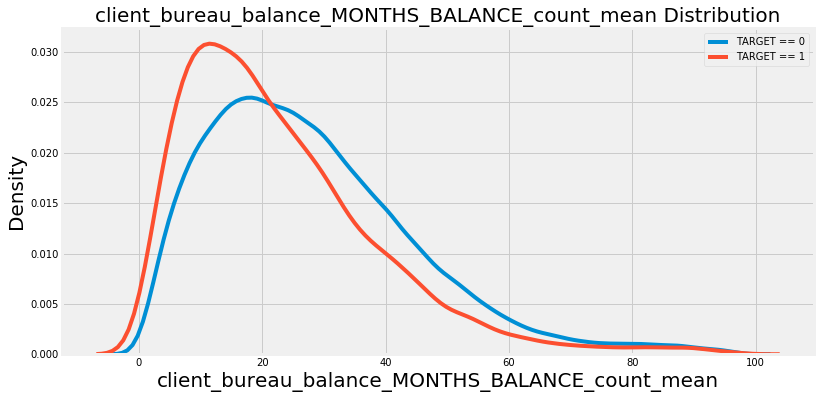

In [98]:
kde_target(var_name = 'client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the Target is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid = 0.3636


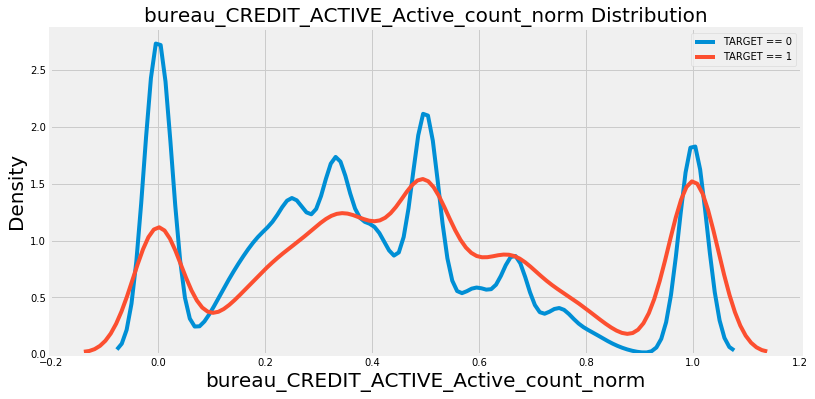

In [99]:
kde_target(var_name = 'bureau_CREDIT_ACTIVE_Active_count_norm', df=train)
# 원래 커널에는 이거 말고 다른 변수 써있는데, 오류나서 다른 것으로 대체

데이터를 merge 시키고 column 이름을 바꾼 것들이 많다보니 column 이름들이 복잡하고 개수가 많음. -> 정리를 해두거나 기억을 해둘 필요가 있다.

In [103]:
# 유사한 분포 변수 삭제하기
# Collinear Variable
# Collinear : 동일선 상의, '상관관계가 높은 변수' 라고 생각하면 될 것 같음.

## Collinear Variables  
We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable.  
PCA나 다른 변수 선택법 사용하기도 함.  

In [102]:
# set the threshold
threshold = 0.8
# empty dictionary to hold correlated variable
above_threshold_vars = {}
# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

# 상관관계가 0.8이 넘는 변수들의 이름 추출.

In [104]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


DataFrame.items() : Iterator over (column name, Series) pairs.  
returning a tuple with the column name and the content as a Series.  

In [105]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training corrs removed shape: ', train_corrs_removed.shape)
print('Testing corrs removed shape: ', test_corrs_removed.shape)

Training corrs removed shape:  (307511, 199)
Testing corrs removed shape:  (48744, 198)


## Modeling
- control: only the data in the application files.
- test one: the data in the application files with all of the data recorded from the bureau and bureau_balance files
- test two: the data in the application files with all of the data recorded from the bureau and bureau_balance files with highly correlated variables removed.  
- 데이터 다르게 해서 3가지 경우로 모델을 돌릴 것임.

In [106]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df


In [125]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [109]:
# Control Data
train_control = pd.read_csv('./input/House/application_train.csv')
test_control = pd.read_csv('./input/House/application_test.csv')

In [126]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798103	train's binary_logloss: 0.548552	valid's auc: 0.760007	valid's binary_logloss: 0.561913
Early stopping, best iteration is:
[269]	train's auc: 0.809199	train's binary_logloss: 0.537755	valid's auc: 0.760273	valid's binary_logloss: 0.555207
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798328	train's binary_logloss: 0.54852	valid's auc: 0.76114	valid's binary_logloss: 0.566651
Early stopping, best iteration is:
[289]	train's auc: 0.812654	train's binary_logloss: 0.534422	valid's auc: 0.761398	valid's binary_logloss: 0.558103
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79964	train's binary_logloss: 0.54685	valid's auc: 0.750232	valid's binary_logloss: 0.564639
Early stopping, best iteration is:
[265]	train's auc: 0.809734	train's binary_logloss: 0.53678	val

In [127]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


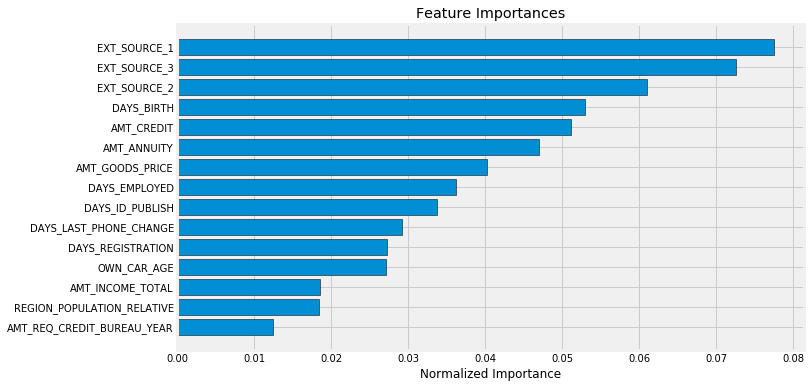

In [128]:
fi_sorted = plot_feature_importances(fi)

함수를 만들어서 하면 반복된 작업을 한줄로 편하게 할 수 있는 장점이 있음.  
하지만 함수에 숙달된 사람이라면 원활하게 가능하지만 너무 복잡한 함수는 가독성을 떨어트리고 복잡함을 유발. -> 혼자만 알 수 있는 code가 되버림.  

이 사람 kernel 에 있는 내용만 다 할 줄 알아도 데이터 분석하는데 문제가 없음. 모든 내용이 충분히 들어있음.  

- 함수 만들어서 사용하는 것의 어려움.
- 여전히 구글링을 통해 찾아가면서 진행해야함. 아직 숙달되지 않았음.  

- 파이썬 데이터 타입에 대한 완벽한 이해가 필요. list, tuple, array, dictionary 등
- def 안에 if, for 문 이용해서 함수 만드는 연습. 계속 연습을 해봐야함. 
- 왜? 라는 생각을 계속 가지고 코드 한줄 한줄 생각을 하면서 하기. 